In [2]:
import os

import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interp
import scipy.ndimage as ndi

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = True

from migdalcalc import migdalcalc as mc
from migdalcalc.migdal import ionization as ion
from migdalcalc.migdal import kinematics as kin

In [3]:
#use the to interpolate the power law tail of the SPS neutron beam
def interp_csv(file_name, skip_header=0):
    plot_data = np.genfromtxt(file_name, delimiter=',', skip_header=skip_header)
    x = list(zip(*plot_data))[0]
    y = list(zip(*plot_data))[1]
    
    return interp.interp1d(x, y, bounds_error=False, fill_value = 0, kind='quadratic')

In [4]:
#used to turn the luminosity distribution to a probability ditribution
def energy_distribution(Lumi):
    norm = integrate.quad(Lumi, 1, 100, limit=100,points=Lumi.x)[0]
    
    return lambda E: 1/(norm)*Lumi(E)

def power_law(Lumi):
    ED = energy_distribution(Lumi)
    power_law_slope = (np.log(ED(50)) - np.log(ED(1)))/(np.log(50))
    power_law_start = ED(1)
    print(f'Slope of power law: {power_law_slope}')
    
    return lambda E: (E/(power_law_start))**(power_law_slope)

In [5]:
#This is to combine the spectra together
def dR_dDeltaE_combined(migdal, Lumi, Ei_min, Ei_max, flux_factor=1, method='elf-ibe'):
    A = migdal.A
    
    #do steps of 1 eV
    a_pts = np.arange(Ei_min, Ei_max, step = 1)
    b_pts = np.append(a_pts[1:], Ei_max)
    
    L = power_law(Lumi)
    
    norm = integrate.quad(L, 1, Ei_max, limit=200)[0]
        
    migdal_spectra = []
    

    for (a, b) in zip(a_pts, b_pts):
        flux = (1/norm)*integrate.quad(L, a, b, limit=200)[0]
        mid_point = (a + b)/2
        spec = migdal.dR_dDeltaE_HS(mid_point, method, flux)
        migdal_spectra.append(spec)
    
    dE_max = (A/(A+1))*Ei_max
    dE_range = np.geomspace(1e-3, dE_max, 100)
    
    dR_dDeltaE_out = []
    
    for dE in dE_range:
        acc = 0
        for mig_spec in migdal_spectra:
            acc += flux_factor*mig_spec(dE)
        
        dR_dDeltaE_out.append(acc)
        
    return interp.interp1d(dE_range, dR_dDeltaE_out, bounds_error = False, fill_value=0)

def dR_dEnr_combined(migdal, Lumi, Ei_min, Ei_max, flux_factor=1):
    A = migdal.A
    
    #do steps of 1 eV
    a_pts = np.arange(Ei_min, Ei_max, step = 0.1)
    b_pts = np.append(a_pts[1:], Ei_max)
    
    L = power_law(Lumi)
    
    norm = integrate.quad(L, 1, Ei_max, limit=200)[0]
        
    elastic_spectra = []
    
    for (a, b) in zip(a_pts, b_pts):
        flux = (1/norm)*integrate.quad(L, a, b, limit=200)[0]
        mid_point = (a + b)/2
        spec = migdal.dR_dEnr_HS_elastic(mid_point, flux)
        elastic_spectra.append(spec)
    
    Enr_range = np.geomspace(1e-6, 4*kin.E0(A, Ei_max), 200)
    dR_dEnr_out = []
    
    for Enr in Enr_range:
        acc = 0
        for el_spec in elastic_spectra:
            acc += flux_factor*el_spec(Enr)
        
        dR_dEnr_out.append(acc)
        
    return interp.interp1d(Enr_range, dR_dEnr_out, bounds_error = False, fill_value=0)


In [6]:
Si_migdal = mc.migdalcalc(target="Si-28", nuclear_data_name="jeff33")
A = Si_migdal.A

In [8]:
print(f'Si xsec at 24 keV {Si_migdal.nuc.SIG(24000)}')

print(Si_migdal.mig.dP_dDeltaE(30, method='gpaw_withLFE'))

Si xsec at 24 keV 1.6939733680861484
2.32556533995934e-09


100
96.55172413793103


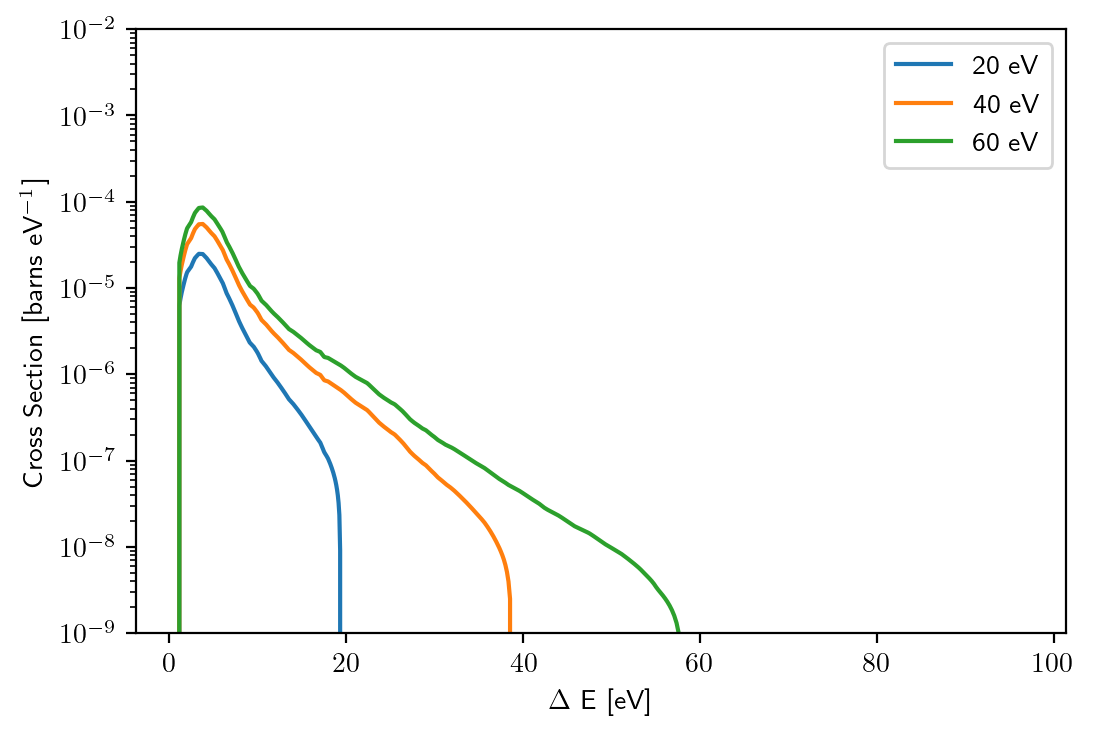

In [6]:
spec_20 = Si_migdal.dR_dDeltaE_HS(20, method='gpaw_withLFE')
spec_40 = Si_migdal.dR_dDeltaE_HS(40, method='gpaw_withLFE')
spec_60 = Si_migdal.dR_dDeltaE_HS(60, method='gpaw_withLFE')

En_max = 100
#Want an En_max that gives a max E_el = 1 eV
E_el_max = 4*kin.E0(A, En_max)
dE_max = (A/(A+1))*En_max
print(En_max)

dE_range = np.geomspace(1, dE_max, 1000)
En_range = np.geomspace(1, En_max, 1000)
Enr_range = np.geomspace(1e-6, 4*kin.E0(28, En_max), 1000)
print(dE_max)

plt.plot(dE_range, spec_20(dE_range), label='20 eV')
plt.plot(dE_range, spec_40(dE_range), label='40 eV')
plt.plot(dE_range, spec_60(dE_range), label='60 eV')
plt.legend()
plt.xlabel(r'$\Delta$ E [eV]')
plt.ylabel(r'Cross Section [barns eV$^{-1}$]')

plt.yscale('log')
plt.ylim(1e-9, 1e-2)
plt.show()

Slope of power law: -0.990691150162993


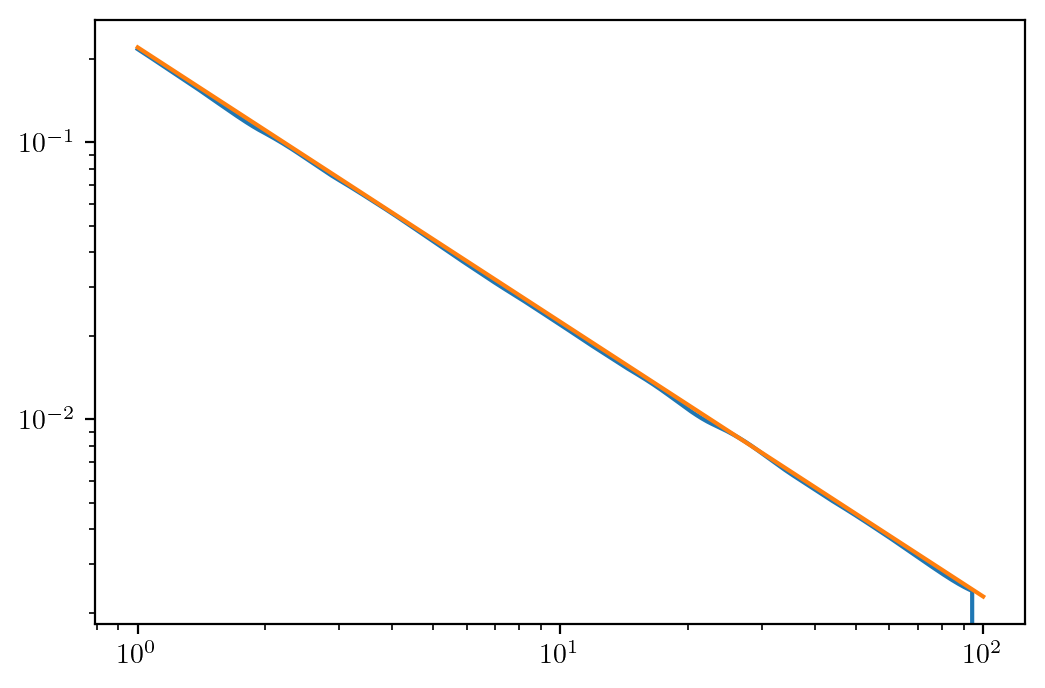

In [7]:
Lumi20x20 = interp_csv('./input/oakridge/STS-20x20.csv')
Lumi100x100 = interp_csv('./input/oakridge/STS-100x100.csv')


plt.plot(En_range, energy_distribution(Lumi20x20)(En_range))
plt.xscale('log')
plt.yscale('log')

pl20x20 = power_law(Lumi20x20)


plt.plot(En_range, pl20x20(En_range))
plt.show()

In [8]:
thickness = 0.1 #1 mm in cm
density =  4.99e22 #per cubic cm
barns_to_cm2 = 1e-24
xsec_to_events_per_nuetron = density*thickness*barns_to_cm2

In [9]:
spec20x20 = dR_dDeltaE_combined(Si_migdal, Lumi20x20, 1, En_max, flux_factor=xsec_to_events_per_nuetron, method='gpaw_withLFE')
spec100x100 = dR_dDeltaE_combined(Si_migdal, Lumi100x100, 1, En_max, flux_factor=xsec_to_events_per_nuetron, method='gpaw_withLFE')

Slope of power law: -0.990691150162993
Slope of power law: -0.985835011966372


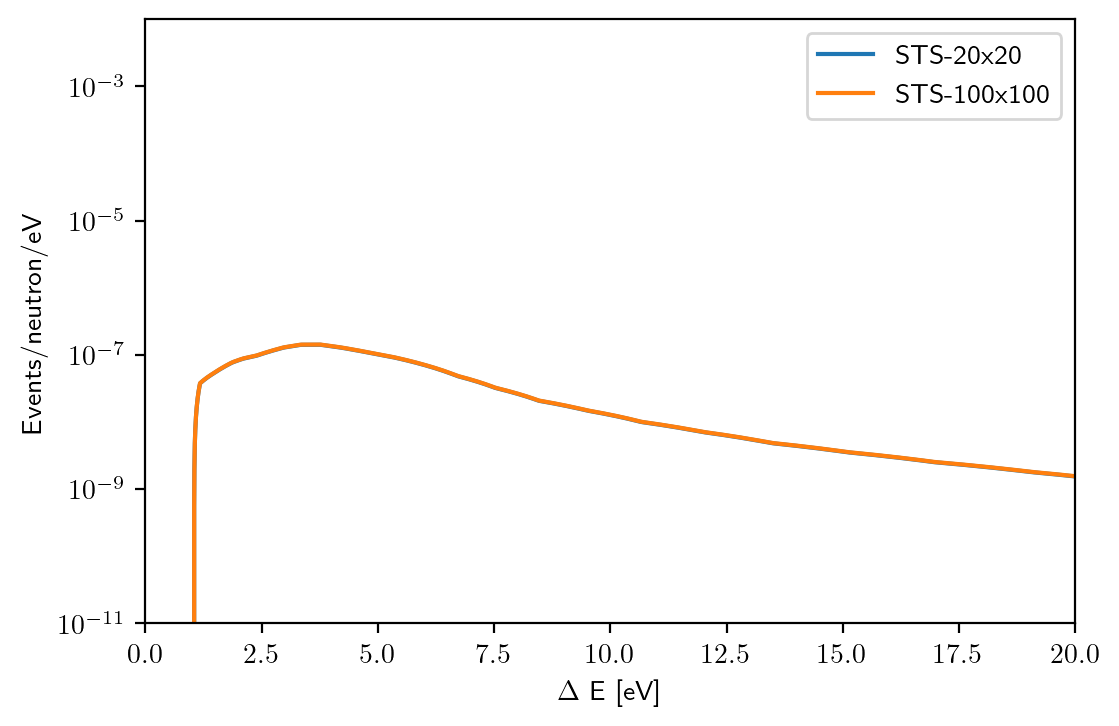

In [10]:
plt.plot(dE_range, spec20x20(dE_range), label="STS-20x20")
plt.plot(dE_range, spec100x100(dE_range), label="STS-100x100")
plt.legend()
plt.yscale('log')
plt.xlabel(r'$\Delta$ E [eV]')
plt.ylabel(r'Events/neutron/eV')
plt.xlim(0, 20)
plt.ylim(1e-11, 1e-2)
plt.show()

6.768030401205735e-07


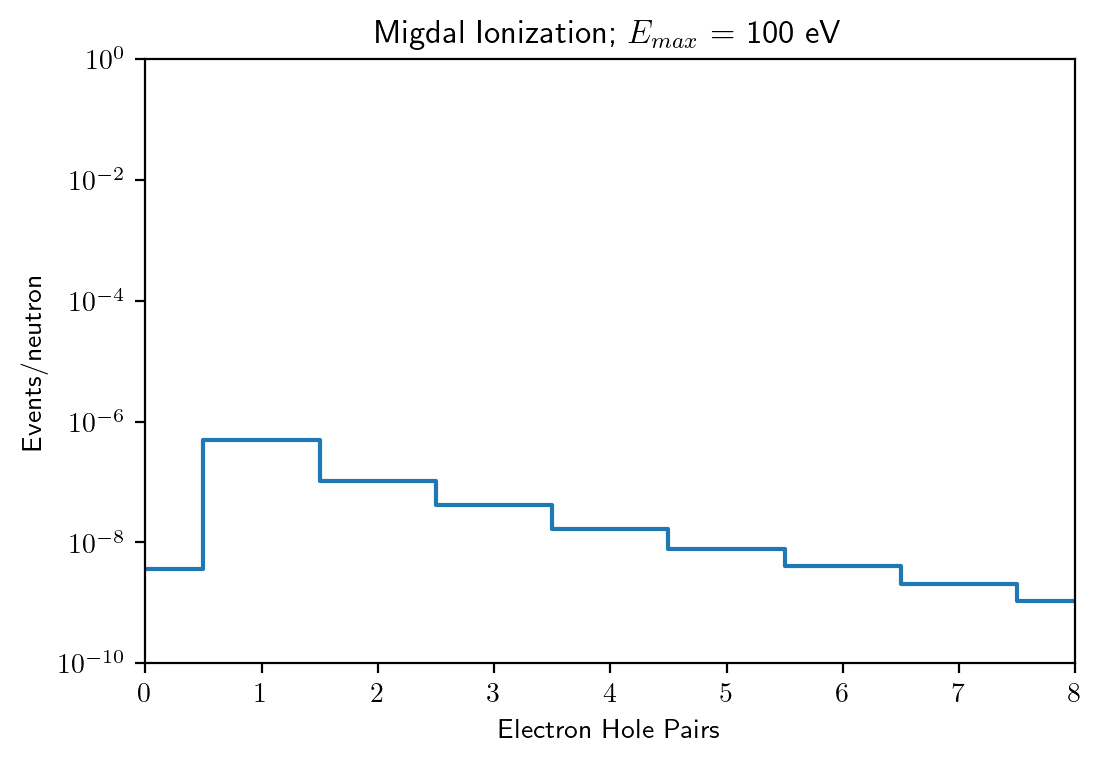

In [11]:
n20x20, r20x20 = ion.Si_electron_spectrum(spec20x20, 0, start_bin=0, number_of_bins=10)
print(np.sum(r20x20))

def clamp(r):
    if r < 1e-10:
        return 0
    return r

rate_arr = [clamp(r) for r in r20x20]

plt.step(n20x20, rate_arr, where='mid')
plt.yscale('log')
plt.ylim(1e-10, 1)
plt.xlim(0, 8)
plt.xlabel("Electron Hole Pairs")
plt.ylabel("Events/neutron")
plt.title(f"Migdal Ionization; $E_{{max}}$ = {En_max} eV")
plt.savefig(f'./plots/Si/lowE/migdal_ionization_cutoff{En_max}eV.jpg',dpi=300,transparent=False)
np.savetxt(f'./plots/Si/lowE/migdal_ionization_cutoff{En_max}eV.csv', list(zip(n20x20, rate_arr)), \
           delimiter=',', fmt='%.5e', header='bin number, rate')
                                                                      
plt.show()



Slope of power law: -0.990691150162993


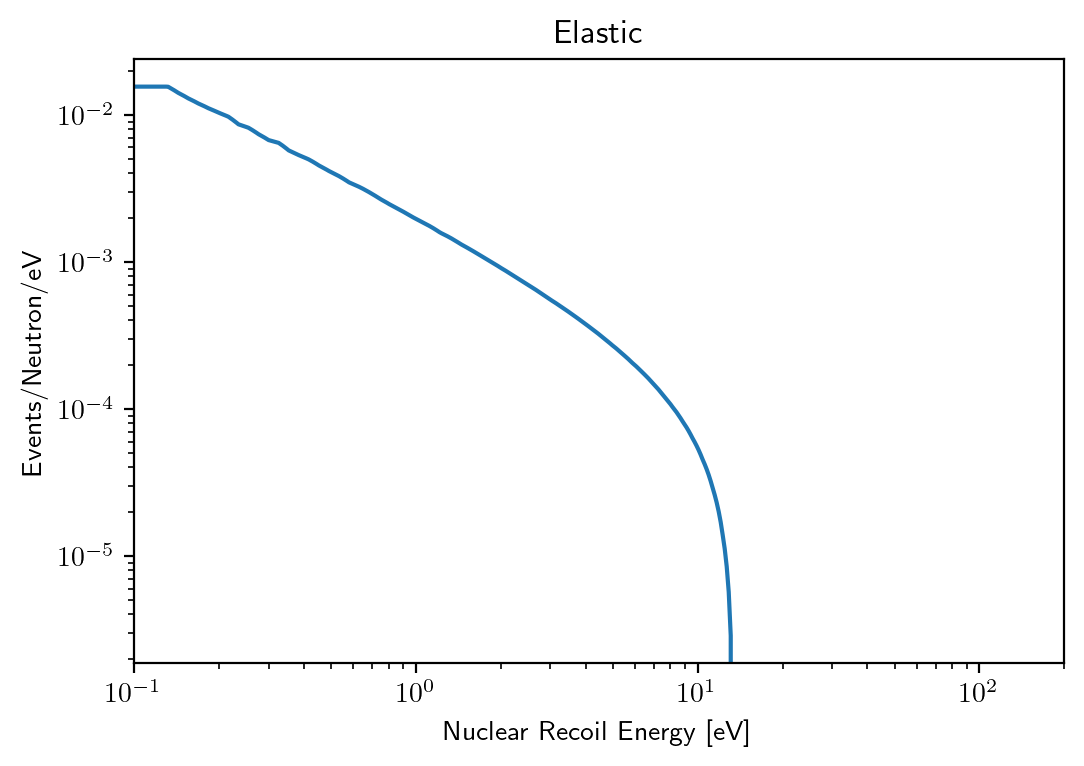

0.009752907999228778


In [12]:
elastic20x20 = dR_dEnr_combined(Si_migdal, Lumi20x20, 1, En_max, flux_factor=xsec_to_events_per_nuetron)

plt.plot(Enr_range, elastic20x20(Enr_range))
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-1, 200)
plt.xlabel('Nuclear Recoil Energy [eV]')
plt.ylabel('Events/Neutron/eV')
plt.title("Elastic")
plt.show()

print(integrate.trapezoid(elastic20x20(Enr_range), Enr_range))
